In [882]:
import numpy.typing as npt
import numpy as np
from numba import config, njit, prange
import pandas as pd
from numpy_atomic import atomic_add, atomic_array_add
import pyfftw
from typing import Tuple, Callable
import math

In [883]:
def fft_3D_real(x: npt.NDArray[np.float32], threads: int) -> npt.NDArray[np.complex64]:
    """Fast Fourier Transform with real inputs

    Uses FFTW library

    Parameters
    ----------
    x : npt.NDArray[np.float32]
        Real grid [N, N, N]
    threads : int
        Number of threads

    Returns
    -------
    npt.NDArray[np.complex64]
        Fourier-space grid [N, N, N // 2 + 1]
    """
    ncells_1d = len(x)
    # Prepare FFTW containers
    x_in = pyfftw.empty_aligned((ncells_1d, ncells_1d, ncells_1d), dtype="float32")
    x_out = pyfftw.empty_aligned(
        (ncells_1d, ncells_1d, ncells_1d // 2 + 1), dtype="complex64"
    )
    # plan FFTW over three axes
    fftw_plan = pyfftw.FFTW(
        x_in,
        x_out,
        axes=(0, 1, 2),
        flags=("FFTW_ESTIMATE",),
        direction="FFTW_FORWARD",
        threads=threads,
    )
    # put in FFTW container
    x_in[:] = x
    # run FFTW
    fftw_plan(x_in, x_out)
    return x_out

In [884]:
@njit(
    ["UniTuple(f4[:],3)(c8[:,:,::1], i8)"],
    fastmath=True,
    cache=True,
    parallel=False,
)
def fourier_grid_to_Pk(
    density_k: npt.NDArray[np.complex64], p: int
) -> Tuple[npt.NDArray[np.float32], npt.NDArray[np.float32], npt.NDArray[np.float32]]:
    """Compute P(k) from Fourier-space density grid with compensated Kernel (Jing 2005)

    Parameters
    ----------
    density_k : npt.NDArray[np.complex64]
        Fourier-space field [N, N, N//2 + 1]
    p : int
        Compensation order (NGP = 1, CIC = 2, TSC = 3)

    Returns
    -------
    Tuple[npt.NDArray[np.float32], npt.NDArray[np.float32]]
        k [in h/Mpc], P(k) [in h/Mpc ** 3], Nmodes
    """
    ncells_1d = len(density_k)
    one = np.float32(1)
    minus_p = -p
    prefactor = np.float32(1.0 / ncells_1d)
    middle = ncells_1d // 2
    k_array = np.zeros(ncells_1d, dtype=np.float32)
    nmodes = np.zeros_like(k_array)
    pk_array = np.zeros_like(k_array)
    for i in prange(ncells_1d):  # FIXME: Make thread safe
        if i == 0:
            i_iszero = True
        else:
            i_iszero = False
        if i > middle:
            kx = -np.float32(ncells_1d - i)
        else:
            kx = np.float32(i)
        kx2 = kx**2
        w_x = np.sinc(kx * prefactor)
        for j in prange(ncells_1d):
            if j == 0:
                j_iszero = True
            else:
                j_iszero = False
            if j > middle:
                ky = -np.float32(ncells_1d - j)
            else:
                ky = np.float32(j)
            w_xy = w_x * np.sinc(ky * prefactor)
            kx2_ky2 = kx2 + ky**2
            for k in prange(middle + 1):
                if i_iszero and j_iszero and k == 0:
                    density_k[0, 0, 0] = 0
                    continue
                kz = np.float32(k)
                w_xyz = w_xy * np.sinc(kz * prefactor)
                tmp = density_k[i, j, k] * w_xyz**minus_p
                delta2 = tmp.real**2 + tmp.imag**2
                k_norm = math.sqrt(kx2_ky2 + kz**2)
                k_index = int(k_norm)
                nmodes[k_index] += one
                k_array[k_index] += k_norm
                pk_array[k_index] += delta2
                """ atomic_add(nmodes, k_index, one)
                atomic_add(k_array, k_index, k_norm)
                atomic_add(pk_array, k_index, delta2) """

    kmax_orszag = int(2 * middle / 3)
    return (
        k_array[1:kmax_orszag] / nmodes[1:kmax_orszag],
        pk_array[1:kmax_orszag] / nmodes[1:kmax_orszag],
        nmodes[1:kmax_orszag],
    )

In [945]:
@njit(
    ["UniTuple(f4[:],3)(c8[:,:,::1], i8)"],
    fastmath=True,
    cache=True,
    parallel=True,
)
def fourier_grid_to_Pk_atom(
    density_k: npt.NDArray[np.complex64], p: int
) -> Tuple[npt.NDArray[np.float32], npt.NDArray[np.float32], npt.NDArray[np.float32]]:
    """Compute P(k) from Fourier-space density grid with compensated Kernel (Jing 2005)

    Parameters
    ----------
    density_k : npt.NDArray[np.complex64]
        Fourier-space field [N, N, N//2 + 1]
    p : int
        Compensation order (NGP = 1, CIC = 2, TSC = 3)

    Returns
    -------
    Tuple[npt.NDArray[np.float32], npt.NDArray[np.float32]]
        k [in h/Mpc], P(k) [in h/Mpc ** 3], Nmodes
    """
    ncells_1d = len(density_k)
    one = np.float32(1)
    minus_p = -p
    prefactor = np.float32(1.0 / ncells_1d)
    middle = ncells_1d // 2
    k_array = np.zeros(ncells_1d, dtype=np.float32)
    nmodes = np.zeros_like(k_array)
    pk_array = np.zeros_like(k_array)
    for i in prange(ncells_1d):  # FIXME: Make thread safe
        if i == 0:
            i_iszero = True
        else:
            i_iszero = False
        if i > middle:
            kx = -np.float32(ncells_1d - i)
        else:
            kx = np.float32(i)
        kx2 = kx**2
        w_x = np.sinc(kx * prefactor)
        for j in prange(ncells_1d):
            if j == 0:
                j_iszero = True
            else:
                j_iszero = False
            if j > middle:
                ky = -np.float32(ncells_1d - j)
            else:
                ky = np.float32(j)
            w_xy = w_x * np.sinc(ky * prefactor)
            kx2_ky2 = kx2 + ky**2
            for k in prange(middle + 1):
                if i_iszero and j_iszero and k == 0:
                    density_k[0, 0, 0] = 0
                    continue
                kz = np.float32(k)
                w_xyz = w_xy * np.sinc(kz * prefactor)
                tmp = density_k[i, j, k] * w_xyz**minus_p
                delta2 = tmp.real**2 + tmp.imag**2
                k_norm = math.sqrt(kx2_ky2 + kz**2)
                k_index = int(k_norm)
                #nmodes[k_index] += one
                #k_array[k_index] += k_norm
                #pk_array[k_index] += delta2
                atomic_add(pk_array, k_index, delta2)
                atomic_add(nmodes, k_index, one)
                atomic_add(k_array, k_index, k_norm)

    kmax_orszag = int(2 * middle / 3)
    return (
        k_array[1:kmax_orszag] / nmodes[1:kmax_orszag],
        pk_array[1:kmax_orszag] / nmodes[1:kmax_orszag],
        nmodes[1:kmax_orszag],
    )

In [4]:
n = 512
df = pd.read_parquet('/home/mabreton/boxlen250_n512_lcdmw7euclid_00000/output_00000/particles.parquet')
part = np.empty((n**3, 3), dtype=np.float32)
part[:,0] = df['x']
part[:,1] = df['y']
part[:,2] = df['z']
df = 0
part

array([[1.8701555e-03, 1.7322303e-03, 2.2304060e-04],
       [1.8182994e-03, 1.7592908e-03, 2.1874905e-03],
       [1.9295217e-03, 3.6005976e-03, 2.8634071e-04],
       ...,
       [9.9972826e-01, 9.9783808e-01, 9.9807554e-01],
       [9.9978232e-01, 9.9968976e-01, 9.9613315e-01],
       [9.9981683e-01, 9.9973381e-01, 9.9816024e-01]], dtype=float32)

In [642]:
part.shape

(134217728, 3)

In [847]:
%timeit TSC(part, n)

3.36 s ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [872]:
%timeit TSC_atom(part, n)

6.28 s ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [868]:
np.allclose(TSC_atom(part, n), TSC(part, n))

True

In [869]:
np.allclose(TSC_atom(part, n), TSC(part, n))

True

In [870]:
np.allclose(TSC_atom(part, n), TSC(part, n))

True

In [871]:
np.allclose(TSC_atom(part, n), TSC(part, n))

True

In [875]:
density = TSC(part, 512)

In [876]:
density_fourier = fft_3D_real(density, 2)

In [952]:
k, pk, nmodes = fourier_grid_to_Pk(density_fourier, 1)

In [953]:
k2, pk2, nmodes2 = fourier_grid_to_Pk_atom(density_fourier, 1)

In [954]:
np.allclose(k, k2), np.allclose(pk, pk2), np.allclose(nmodes, nmodes2) 

(False, False, True)

In [955]:
np.max(np.abs(k-k2)), np.max(np.abs(pk-pk2)), np.max(np.abs(nmodes-nmodes2)) 

(0.0015792847, 2048.0, 0.0)

In [950]:
%timeit fourier_grid_to_Pk(density_fourier, 1)

1.25 s ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [951]:
%timeit fourier_grid_to_Pk_atom(density_fourier, 1)

1.53 s ± 82.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


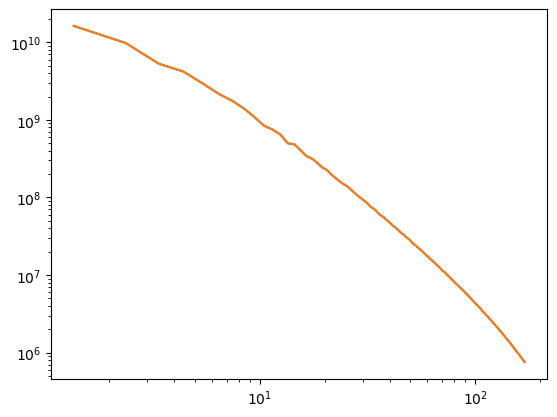

In [937]:
import matplotlib.pyplot as plt
plt.loglog(k, pk)
plt.loglog(k2, pk2)
plt.show()

In [688]:
CIC(np.ascontiguousarray(part[::1]), 4)

array([[[1991922.8, 2007410. , 2012573.2, 2005993.1],
        [2013964.2, 2026520.8, 2025529.4, 2022387. ],
        [2028089.8, 2010004. , 2035549.4, 2052920.2],
        [2022883.9, 2029024.8, 2038656.5, 2045881.1]],

       [[2014391.6, 2015700. , 2012673.8, 2029774. ],
        [2027988.4, 2039210.6, 2038126.4, 2037520. ],
        [2043821.8, 2028983.1, 2052045.6, 2074071.1],
        [2042645.8, 2035958.2, 2048480.8, 2056390.4]],

       [[2027400.5, 2031256.2, 2027470.9, 2038353.4],
        [2039252. , 2051124.1, 2060574.5, 2055378.6],
        [2053823.5, 2055199.4, 2054283.2, 2060852.9],
        [2062002.8, 2068373.5, 2061343.2, 2061970.8]],

       [[2040157.6, 2047135.2, 2061017.1, 2056276.6],
        [2045928.2, 2060392.8, 2057735.4, 2062411.8],
        [2063068.6, 2059593.5, 2066176.8, 2076277.4],
        [2068358. , 2073634.9, 2081955.4, 2077031.6]]], dtype=float32)

In [682]:
part

array([[1.8701555e-03, 1.7322303e-03, 2.2304060e-04],
       [1.8182994e-03, 1.7592908e-03, 2.1874905e-03],
       [1.9295217e-03, 3.6005976e-03, 2.8634071e-04],
       ...,
       [9.9972826e-01, 9.9783808e-01, 9.9807554e-01],
       [9.9978232e-01, 9.9968976e-01, 9.9613315e-01],
       [9.9981683e-01, 9.9973381e-01, 9.9816024e-01]], dtype=float32)

In [683]:
part[::-1]

array([[9.9981683e-01, 9.9973381e-01, 9.9816024e-01],
       [9.9978232e-01, 9.9968976e-01, 9.9613315e-01],
       [9.9972826e-01, 9.9783808e-01, 9.9807554e-01],
       ...,
       [1.9295217e-03, 3.6005976e-03, 2.8634071e-04],
       [1.8182994e-03, 1.7592908e-03, 2.1874905e-03],
       [1.8701555e-03, 1.7322303e-03, 2.2304060e-04]], dtype=float32)

In [60]:
TSC_atom(part, n//8)[0]

array([[536.0506 , 534.1143 , 515.75616, ..., 520.8015 , 517.7701 ,
        511.84616],
       [538.8943 , 544.03845, 529.2659 , ..., 505.04218, 506.19293,
        515.43787],
       [514.29083, 528.5897 , 526.22864, ..., 483.8086 , 487.28735,
        498.60452],
       ...,
       [502.4444 , 491.18967, 492.52216, ..., 518.262  , 522.6878 ,
        504.82483],
       [488.86624, 487.30377, 506.6448 , ..., 510.04434, 515.23004,
        499.91934],
       [513.78577, 510.17105, 504.80554, ..., 505.55618, 512.28516,
        507.03226]], dtype=float32)